# Lab — Scalable GNN

Today we will talk about application of Graph Neural Networks to large graphs, specifically, we will explain in details how GraphSAINT (Graph Sampling based Inductive Learning Method https://arxiv.org/abs/1907.04931) works.

Classic GCN samplings works in layer-wise nature. For example, GraphSAGE samples the neighborhood of each node to aggregate into the anchor node embedding. The general idea of GraphSAINT is to sample subgraphs from the large graph and train the GCN on it. However, such sampling induces bias due to more probable sampling of high degree nodes. To eliminate it, authors propose several normalization and variance-reduction techniques.

In [14]:
! pip install ogb -q
! pip install dgl-cu111 -f https://data.dgl.ai/wheels/repo.html -q

In [15]:
import dgl
import math
from torch.utils.data import Dataset, DataLoader
from abc import ABC, abstractmethod
import torch
from torch import nn
import torch.nn.functional as F
import dgl.function as fn
from dgl.sampling import random_walk, pack_traces

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In this task we are going to work with `ogbn-arxiv` dataset.

The `ogbn-arxiv` dataset is a directed graph, representing the citation network between all Computer Science (CS) arXiv papers indexed by MAG [1]. Each node is an arXiv paper and each directed edge indicates that one paper cites another one. Each paper comes with a 128-dimensional feature vector obtained by averaging the embeddings of words in its title and abstract.

**Prediction task**: The task is to predict the 40 subject areas of arXiv CS papers, e.g., cs.AI, cs.LG, and cs.OS, which are manually determined (i.e., labeled) by the paper’s authors and arXiv moderators. With the volume of scientific publications doubling every 12 years over the past century, it is practically important to automatically classify each publication’s areas and topics. Formally, the task is to predict the primary categories of the arXiv papers, which is formulated as a 40-class classification problem.

In [16]:
from ogb.nodeproppred import DglNodePropPredDataset, Evaluator

d_name = "ogbn-arxiv"

dataset = DglNodePropPredDataset(name=d_name)

split_idx = dataset.get_idx_split()
train_idx, valid_idx, test_idx = split_idx["train"], split_idx["valid"], split_idx["test"]
graph, label = dataset[0]

graph.ndata["label"] = label.view(-1)
graph.ndata["is_train"] = torch.zeros(graph.num_nodes())
graph.ndata["is_train"][train_idx] = 1
graph.ndata["is_train"] = graph.ndata["is_train"].type(torch.BoolTensor)

graph = graph.to(device)

### Subgraph sampling

<img src='https://raw.githubusercontent.com/netspractice/advanced_gnn/main/lab_scalable_gnn/graph_sampling.png' width=700>

In this task we will define the abstract SamplerBase class and specific realizations of it for different motifs sampling (Node, Edge and Random Walks).

The `SamplerBase` inherit the `torch.utils.data.Dataset`. `SamplerBase` takes two input parameters:

1. Graph `g` is our graph to be sampled
2. `num_nodes` is an expected number of nodes for each subgraph

The torch Dataset requires at least two functions to be defined: `__len__` and `__getitem__`.

First function should return the total number of samples in the dataset. In the given setting we want to cover the all nodes by subgraphs, so the length of dataset will be equal to the ceil of number of nodes in the graph divided by the number of nodes per subgraph.

The second one should return the sample subgraph. To unify it between different sampling techniques (Nodes, Edges and Random Walks), we will call abstract method `__sample__` that returns list of nodes for subgraph. After, we will take the subgraph from the given nodes.



In [17]:
class SamplerBase(Dataset, ABC):
  def __init__(self, g, num_nodes, seed=0):
    self.g = g
    self.num_nodes = num_nodes
    torch.manual_seed(seed)

  @abstractmethod
  def __sample__(self):
    raise NotImplemented
  
  def __len__(self):
    return math.ceil(self.g.num_nodes() / self.num_nodes)

  @abstractmethod
  def __getitem__(self, idx):
    raise NotImplemented

After defining the base for samplers we can define the specific realizations.

The `NodeSampler` just samples with replacement nodes from the graphs according to its input degree.

In [20]:
class NodeSampler(SamplerBase):
  def __init__(self, *args, **kwargs):
    self.prob = None
    super(NodeSampler, self).__init__(*args, **kwargs)

  def __sample__(self):
    if self.prob is None:
      self.prob = self.g.in_degrees().float().clamp(min=1).to(device)
    return torch.multinomial(self.prob, num_samples=self.num_nodes, replacement=True).unique()

  def __getitem__(self, idx):
    subgraph_nodes = self.__sample__()
    return dgl.node_subgraph(self.g, subgraph_nodes)

In [21]:
node_sampler = NodeSampler(graph, 100)

subg = node_sampler.__getitem__(0)
assert subg.num_nodes() > 90
assert subg.num_nodes() < 110

`EdgeSampler` works as follows:

1. Samples edges with _unnormalized_ probability 
$$p_{u,v} = \frac{1}{\text{deg}(u)} + \frac{1}{\text{deg}(v)}$$
2. Returns unique list of nodes defined by the edges

In [22]:
from time import time

class EdgeSampler(SamplerBase):
  def __init__(self, num_edges, **kwargs):
    self.prob = None
    self.num_edges = num_edges
    super(EdgeSampler, self).__init__(num_nodes=2 * num_edges, **kwargs)

  def __sample__(self):
    src, dst = self.g.edges()
    if self.prob is None:
      src_degrees = self.g.in_degrees(src).float().clamp(min=1)
      dst_degrees = self.g.in_degrees(dst).float().clamp(min=1)

      self.prob = (1. / src_degrees + 1. / dst_degrees).to(device)
      self.prob /= self.prob.sum()
    return torch.multinomial(self.prob, self.num_edges, replacement=False)

  def __getitem__(self, idx):
    subgraph_edges = self.__sample__()
    return dgl.edge_subgraph(self.g, subgraph_edges)

In [23]:
edge_sampler = EdgeSampler(num_edges=256, g=graph)

subg = edge_sampler.__getitem__(0)
assert subg.num_edges() == 256

`RandomWalkSampler` works as follows:

1. Selects the random root nodes from graph
2. Uses `random_walk` method from dgl to sample random walks
3. Packs random walk traces with `pack_traces` from dgl
4. Returns the received node list from `3`

In [24]:
class RandomWalkSampler(SamplerBase):
  def __init__(self, num_roots, length, **kwargs):
    self.num_roots, self.length = num_roots, length
    super(RandomWalkSampler, self).__init__(num_nodes=num_roots * length, **kwargs)
  
  def __sample__(self):
    sampled_roots = torch.randint(0, self.g.num_nodes(), (self.num_roots,))
    traces, types = random_walk(self.g, nodes=sampled_roots, length=self.length)
    sampled_nodes, _, _, _ = pack_traces(traces, types)
    return  sampled_nodes.unique()
  
  def __getitem__(self, idx):
    subgraph_nodes = self.__sample__()
    return dgl.node_subgraph(self.g, subgraph_nodes)

In [25]:
rw_sampler = RandomWalkSampler(num_roots=20, length=10, g=graph)

### Precompute normalizations

Subgraph sampling induce the bias towards nodes with high degrees due to larger probability to be sampled. So, authors of GraphSAINT propose to use the normalizations. To decrease train time, they fix normalization before starting training by precomputing it on the several samples.

To do so, we need to sample several batches of subgraphs and calculate edge, loss and aggregation norms.

To simplify our code, we will use custom collate function that will extract node and edge indices and calculate summed number of nodes in the sampled subgraphs.

Method `collate_batch` should iterate over each subgraph in the batch, and calculate three variables:

1. Number of nodes over all graphs in the batch (not unique, total)
2. List of lists with source node ids (`dgl.NID` param of `graph.ndata`)
3. List of lists with source edge ids (`dgl.EID` param of `graph.edata`)

In [26]:
def collate_batch(batch):
  sum_num_nodes = 0
  subgraphs_nids_list = []
  subgraphs_eids_list = []
  for subg in batch:
      sum_num_nodes += subg.num_nodes()
      subgraphs_nids_list.append(subg.ndata[dgl.NID])
      subgraphs_eids_list.append(subg.edata[dgl.EID])
  return sum_num_nodes, subgraphs_nids_list, subgraphs_eids_list

In [27]:
batch = [graph.subgraph(range(i * 100, (i + 1) * 100)) for i in range(10)]
sum_num_nodes, subgraphs_nids_list, subgraphs_eids_list = collate_batch(batch)

assert sum_num_nodes == 1000
assert len(subgraphs_nids_list) == 10
assert len(subgraphs_eids_list) == 10
assert min(subgraphs_nids_list[3]) == 300
assert max(subgraphs_nids_list[3]) == 399

Now, we need to define method to compute _aggregator_ and _loss normalizations_, given the node and edge occurencies. The loss normalization is defined as follows:

$$\lambda_{i} = \frac{N_\text{samples}}{N_{i} \cdot N_\text{nodes}},$$

where $N_\text{samples}$ is a number of subgraphs in the precomputing stage, $N_{i}$ is a number of occurencies of node $i$ in subgraphs and $N_\text{nodes}$ is a total number of nodes in the graph. The aggregator normalization is defined as follows:

$$\alpha_{u,v} = \frac{p_{u,v}}{p_v},$$

where $p_{u,v}$ is a probability of edge from node $u$ to node $v$ and $p_v$ is a probability of node $v$. To calculate it, one can use dgl message function `fn.e_div_v`.


$\alpha$ will be used as an edge weight in the `GraphConv` layer further. The $\lambda$ will be used as a observation weight while cross-entropy calculation.

In [28]:
def compute_norm(g, node_counter, edge_counter, num_subgraphs):
  node_counter[node_counter == 0] = 1
  edge_counter[edge_counter == 0] = 1

  loss_norm = num_subgraphs / node_counter / g.num_nodes()
  g.ndata['n_c'] = node_counter
  g.edata['e_c'] = edge_counter
  g.apply_edges(fn.e_div_v('e_c', 'n_c', 'a_n'))
  aggr_norm = g.edata.pop('a_n')

  g.ndata.pop('n_c'), g.edata.pop('e_c')

  return aggr_norm, loss_norm

In [29]:
g = dgl.rand_graph(10, 30)
aggr, loss = compute_norm(
    g, 
    torch.arange(10).type(torch.FloatTensor), 
    torch.arange(30).type(torch.FloatTensor), 
    100
)
assert round(loss[-1].item(), 2) == 1.11

Now we are ready to write function for precomputation stage.

It should work as follows:

1. Initialize DataLoader with input sampler (do not forget to pass the `collate_fn=collate_batch` parameter)
2. Iterate until data left or until we receive `num_samples` for each node (break iteration if `num sampled nodes > num_samples * sampler.g.num_nodes`)
3. On each iteration calculate
  1. total number of sampled nodes 
  2. total number of subgraphs (`num_subgraphs`)
  3. counters for each node (`node_counter`) and edge occurencies (`edge_counter`)



In [30]:
def precompute_norm(sampler, num_samples, batch_size, num_workers):
  loader = DataLoader(
      sampler, 
      batch_size=batch_size, 
      shuffle=True, 
      num_workers=num_workers, 
      collate_fn=collate_batch, 
      drop_last=False)
  node_counter = torch.zeros((sampler.g.num_nodes(),)).to(device)
  edge_counter = torch.zeros((sampler.g.num_edges(),)).to(device)

  N = 0
  sampled_nodes = 0
  for num_nodes, subgraphs_nids, subgraphs_eids in loader:
    sampled_nodes += num_nodes
    sampled_nodes_idx, _node_counts = torch.unique(
        torch.cat(subgraphs_nids), return_counts=True)
    node_counter[sampled_nodes_idx] += _node_counts

    sampled_edges_idx, _edge_counts = torch.unique(
        torch.cat(subgraphs_eids), return_counts=True)
    edge_counter[sampled_edges_idx] += _edge_counts
    N += len(subgraphs_nids)

    if sampled_nodes > num_samples * sampler.g.num_nodes():
      break
    
  return compute_norm(sampler.g, node_counter, edge_counter, N)

In [31]:
sampler = NodeSampler(graph, 100)
aggr, loss = precompute_norm(sampler, 100, 512, 0) # num_workers = 0 due to CUDA inference

assert round(aggr[1].item(), 3) == 0.014
assert round(loss[1].item(), 2) == 0.01

### Put all together

In this task we will train the GCN using the GraphSAINT sampling approach.

Firstly, we need to define the network. It will be vanilla GCN. However, we want to apply the edge and loss normalizations. So the forward function should pass the `edge_weight` to the layer inference.

In [32]:
from dgl.nn import GraphConv

class GCN(nn.Module):
  def __init__(self, in_dim, out_dim, hid_dim=8, n_layers=3, dropout_rate=0.1):
    super(GCN, self).__init__()
    self.layers = nn.ModuleList()
    self.layers.append(GraphConv(in_dim, hid_dim, norm="right", activation=F.relu))
    for i in range(n_layers - 2):
      self.layers.append(GraphConv(hid_dim, hid_dim, norm="right", activation=F.relu))
    self.layers.append(GraphConv(hid_dim, out_dim, norm="right"))
    self.dropout = nn.Dropout(dropout_rate)
  
  def forward(self, graph, use_norm=True):
    h = graph.ndata["feat"]
    for layer in self.layers[:-1]:
      h = self.dropout(h)
      h = layer(graph, h, edge_weight=graph.edata["aggr_norm"] if use_norm else None)
    return self.layers[-1](graph, h, edge_weight=graph.edata["aggr_norm"] if use_norm else None)

Now let us define all requirement for training

In [33]:
def collate(batch):
  return batch[0]

graph = graph.add_self_loop()
sampler = NodeSampler(graph, 512)
sampler.g.edata["aggr_norm"], sampler.g.ndata["loss_norm"] = \
  precompute_norm(sampler, 1000, 512, 0)
sampler.g = sampler.g.to(device)
loader = DataLoader(sampler, batch_size=1, collate_fn=collate)
model = GCN(graph.ndata['feat'].size(1), label.max().item() + 1)
model = model.to(device)
evaluator = Evaluator(d_name)

The one epoch trainer is usual. However, we need to apply the loss normalization technique:

1. Calculate loss for each point (`reduction="none"`)
2. Multiply loss by normalization
3. Reduce loss with mean

In [34]:
def train(model, loader, optimizer):  
  model.train()
  for subgraph in tqdm(loader):
    subgraph = subgraph.to(device)
    subgraph = dgl.add_self_loop(subgraph)
    p = model(subgraph)
    optimizer.zero_grad()

    loss = F.cross_entropy(
        p.to(torch.float32)[subgraph.ndata['is_train']], 
        subgraph.ndata['label'][subgraph.ndata['is_train']], 
        reduction="none")
    loss = (loss * subgraph.ndata["loss_norm"][subgraph.ndata['is_train']]).mean()

    loss.backward()
    optimizer.step()
  


def evaluate(model, g, labels, mask):
  model.eval()
  with torch.no_grad():
    logits = model(g, use_norm=False)
    logits = logits[mask].argmax(dim=1, keepdims=True)
    labels = labels[mask]
    return evaluator.eval({
        'y_true': labels,
        'y_pred': logits
    })

Now let us run the pipeline and see our results

In [35]:
from tqdm import tqdm
from matplotlib import pyplot as plt
from IPython.display import clear_output
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import os
log_dir = "./"

def run(model, loader):
  optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
  scheduler = ReduceLROnPlateau(optimizer, factor=0.9)
  best_acc = -1

  scores = {
        "train": [],
        "validation": [],
        "test": [],
    }
  for epoch in range(500):
    train(model, loader, optimizer)

    model.eval()
    if epoch % 10 == 0:
      clear_output()
      scores['train'].append(evaluate(model, graph, label, train_idx)["acc"])
      scores['validation'].append(evaluate(model, graph, label, valid_idx)["acc"])
      scores['test'].append(evaluate(model, graph, label, test_idx)["acc"])

      plt.title("Score dynamics. train: {:.4f}, validation: {:.4f}, test: {:.4f}".format(
          scores['train'][-1], scores['validation'][-1], scores['test'][-1]))
      plt.plot(scores['train'], label="train")
      plt.plot(scores['validation'], label="validation")
      plt.plot(scores['test'], label="test")
      plt.legend()
      plt.show()
      
      if scores['validation'][-1] > best_acc:
        best_acc = scores['validation'][-1]
        print('new best val score:', best_acc)
        torch.save(model.state_dict(), os.path.join(
            log_dir, 'best_model.pkl'))
      scheduler.step(scores['validation'][-1])

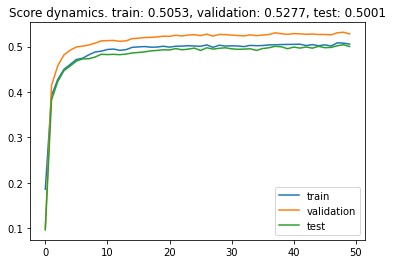

100%|██████████| 331/331 [00:03<00:00, 87.00it/s]


In [36]:
run(model, loader)

In [ ]:
sampler = EdgeSampler(g=graph, num_edges=256)
sampler.g.edata["aggr_norm"], sampler.g.ndata["loss_norm"] = precompute_norm(sampler, 1000, 512, 0)
sampler.g.edata["aggr_norm"] = sampler.g.edata["aggr_norm"].to(device)
sampler.g.ndata["loss_norm"] = sampler.g.ndata["loss_norm"].to(device)
sampler.g = sampler.g.to(device)
loader = DataLoader(sampler, batch_size=1, collate_fn=collate)
model = GCN(graph.ndata['feat'].size(1), label.max().item() + 1)
model = model.to(device)

run(model, loader)

In [ ]:
sampler = RandomWalkSampler(num_roots=10000, length=100, g=graph)
sampler.g.edata["aggr_norm"], sampler.g.ndata["loss_norm"] = precompute_norm(sampler, 1000, 512, 0)
sampler.g = sampler.g.to(device)
loader = DataLoader(sampler, batch_size=1, collate_fn=collate, num_workers=8)
model = GCN(graph.ndata['feat'].size(1), label.max().item() + 1)
model = model.to(device)

run(model, loader)